In [24]:
# from google.colab import drive
# drive.mount('/content/drive')

In [25]:
!python3 -c "import torch; print(torch.__version__)"

!pip3 install networkx

2.1.0+cu121


In [26]:
#!pip3 install torch torchvision
import torch
import torch.nn as nn
import numpy as np
from numpy import inf
from tqdm import tqdm

from timeit import default_timer as timer

import networkx as nx

import matplotlib.pyplot as plt
import pickle

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(0)

In [27]:
class BaseGNNLayer(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        lim = 1
        self.w_self = (-2 * lim * torch.rand(input_dim, output_dim) + lim).to(device)
        self.w_neigh = (-2 * lim * torch.rand(input_dim, output_dim) + lim).to(device)

    def forward(self, node_feats, adj_matrix):
        node_feats_self = torch.mm(node_feats, self.w_self)
        node_feats_neigh = torch.mm(torch.mm(adj_matrix, node_feats), self.w_neigh)

        next_node_feats = node_feats_self + \
                        node_feats_neigh
        return next_node_feats

In [28]:
# Truncated Sigmoid
threshold = 1
def act_fn(x):
    return torch.clamp(x, min=-threshold, max=threshold)

In [29]:
class BaseGNNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=act_fn):
        super().__init__()
        self.layers = nn.ModuleList([BaseGNNLayer(input_dim, hidden_dim)]).to(device)
        for i in range(num_layers - 2):
            self.layers.append(BaseGNNLayer(hidden_dim, hidden_dim).to(device))
        self.layers.append(BaseGNNLayer(hidden_dim, output_dim).to(device))
        self.act_fn = act_fn

    def forward(self, x, adj_matrix):

        for layer in self.layers:
            x = self.act_fn(layer(x, adj_matrix))
        return x

In [30]:
class MLPModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=torch.tanh):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)]).to(device)
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim).to(device))
        self.layers.append(nn.Linear(hidden_dim, output_dim).to(device))
        self.act_fn = act_fn

    def forward(self, x):
        for layer in self.layers:
            x = self.act_fn(layer(x))
        return torch.sigmoid(x)

In [31]:
def loader(A):
  n = len(A)
  for i in range(n):
    yield A[i]

# Model Evaluation

In [32]:
def get_csv(graph_func, NUM_NODES, d=64, r=0.5, layers=[3], num_models=10, calc_adj_upfront=True):
  """
  graph_func(graph_dim, r) -> adj_matrix
  """
  csv = []
  # Calculate graphs upfront
  A = [];
  if calc_adj_upfront:
    for graph_dim in NUM_NODES:
        start_time = timer()
        for idx in range(2**5):
            A.append(graph_func(graph_dim, r))
        print(f'Graphs of size {graph_dim} generated in {timer()-start_time}')
    print(f"Generated {len(A)} graphs.")

  for num_layers in layers:
    for mpnn_idx in range(num_models):  # There will be 10 plots.
        # Initialize random BaseGNN model with sum aggregation.
        base_gnn = BaseGNNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                num_layers=num_layers, act_fn=act_fn).to(device)

        # Initialize random MLP classifier acting on final mean-pooled embedding.
        mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1,
                    num_layers=2, act_fn=torch.tanh).to(device)

        proportions = []
        adj_loader = loader(A)
        # Create plot with x-axis an increasing seq of number of graph nodes.
        for graph_dim in NUM_NODES:
            classifications = []

            for idx in range(2**5):
                # Generate graph to be fed to the BaseGNN.

                #adj_matrix = graph_func(graph_dim, r).to(device)
                if calc_adj_upfront:
                    adj_matrix = next(adj_loader).to(device)
                else:
                    adj_matrix = graph_func(graph_dim, r).to(device)
                #assert adj_matrix.size(dim=0) == graph_dim
                initial_node_feats = torch.rand(graph_dim, d).to(device)

                # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                output = base_gnn(initial_node_feats, adj_matrix).mean(axis=0)

                # Apply MLP classifier to the resulting output.
                apply_classifier = mlp(output)

                # If smaller than 1/2, output 0, else output 1.
                if apply_classifier <= 0.5:
                    classifications.append(0)
                else:
                    classifications.append(1)

            # Calculate proportion of graphs classified as 1.
            classifications = np.array(classifications)
            proportions.append((classifications == 1).sum())

        csv.append([d,r,num_layers, mpnn_idx, proportions])
        print(csv[-1])
  return csv

# Plotting function

In [73]:
def plot_csv(csv_layers, num_samples, subtitles, xx, log_scale=True, title=""):
  num_plots = len(csv_layers)
  fig, axs = plt.subplots(1, num_plots, figsize=(21,7))

  for i, csv_layer in enumerate(csv_layers):#, csv_numLayer_2, csv_numLayer_3]):
    csv_layer = [item[-1] for item in csv_layer]
    for y in csv_layer:
      y = [item/num_samples for item in y]
      axs[i].plot(xx[i], y)
    axs[i].set_xlabel('Graph sizes')
    axs[i].set_ylabel('Fraction of graphs classified as 1')
    if log_scale:
      axs[i].set_xscale("log")
    axs[i].set_title(subtitles[i], fontsize=16)

  fig.suptitle(title, fontsize=20)
  fig.show()

In [34]:
def get_er_graph(graph_dim, r):
  half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                     torch.eye(graph_dim)))
  adj_matrix = half_matrix + half_matrix.T
  return adj_matrix

def get_ba_graph(graph_dim, r=None):
  G = nx.barabasi_albert_graph(graph_dim, 3)#, graph_dim // 2)
  A = nx.adjacency_matrix(G)
  adj_matrix = torch.tensor(A.todense()).float() #.to(device)
  return adj_matrix

def get_their_ba_graph(graph_dim, r=None):
  G = nx.barabasi_albert_graph(graph_dim, graph_dim //2)#, graph_dim // 2)
  A = nx.adjacency_matrix(G)
  adj_matrix = torch.tensor(A.todense()).float() #.to(device)
  return adj_matrix

def get_regular_graph(graph_dim, r = None):
  G = nx.random_regular_graph(d=3, n=graph_dim)
  A = nx.adjacency_matrix(G)
  adj_matrix = torch.tensor(A.todense()).float() #.to(device)
  return adj_matrix

def get_ext_ba_graph(graph_dim, r = None):
  G = nx.extended_barabasi_albert_graph(n=graph_dim, m=1, p=0.5, q=0.1)
  A = nx.adjacency_matrix(G)
  adj_matrix = torch.tensor(A.todense()).float() #.to(device)
  return adj_matrix

# Evaluate and Plot

Erdos-Renyi

In [48]:
NUM_NODES_er = [10, 50, 100, 500, 1000, 2000, 5000, 10000]
csv_er = get_csv(get_er_graph, NUM_NODES_er, calc_adj_upfront=False)

[64, 0.5, 3, 0, [31, 30, 30, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 1, [32, 32, 31, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 2, [0, 0, 0, 0, 0, 0, 0, 0]]
[64, 0.5, 3, 3, [30, 32, 32, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 4, [17, 25, 23, 20, 27, 32, 32, 32]]
[64, 0.5, 3, 5, [3, 3, 6, 8, 13, 5, 5, 6]]
[64, 0.5, 3, 6, [20, 21, 11, 2, 2, 2, 0, 0]]
[64, 0.5, 3, 7, [6, 23, 31, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 8, [18, 19, 22, 13, 8, 3, 0, 0]]
[64, 0.5, 3, 9, [31, 31, 32, 32, 32, 32, 32, 32]]


BA

In [41]:
### BA GRAPH
NUM_NODES_ba = [10, 50, 100, 500, 1000, 1500, 2000]
csv_ba = get_csv(get_ba_graph, NUM_NODES_ba)

Graphs of size 10 generated in 0.01613433099919348
Graphs of size 50 generated in 0.031086279999726685
Graphs of size 100 generated in 0.045406654999169405
Graphs of size 500 generated in 0.20258144599938532
Graphs of size 1000 generated in 0.7263664649999555
Graphs of size 1500 generated in 0.9338795299991034
Graphs of size 2000 generated in 1.4505181989989069
Generated 224 graphs.
[64, 0.5, 3, 0, [30, 32, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 1, [29, 32, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 2, [25, 25, 29, 32, 32, 32, 32]]
[64, 0.5, 3, 3, [0, 1, 0, 0, 0, 0, 0]]
[64, 0.5, 3, 4, [32, 32, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 5, [32, 32, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 6, [1, 0, 0, 0, 0, 0, 0]]
[64, 0.5, 3, 7, [25, 31, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 8, [22, 12, 11, 5, 6, 2, 0]]
[64, 0.5, 3, 9, [24, 31, 32, 32, 32, 32, 32]]


In [37]:

NUM_NODES_ba_their = [10, 50, 100, 500, 1000, 1500, 2000]
csv_their_ba = get_csv(get_their_ba_graph, NUM_NODES_ba)

Graphs of size 10 generated in 0.04485971900066943
Graphs of size 50 generated in 0.49747397099963564
Graphs of size 100 generated in 1.3672761440002432
Graphs of size 500 generated in 14.449885707999783
Graphs of size 1000 generated in 47.45460933800041
Graphs of size 1500 generated in 111.31545217599978
Graphs of size 2000 generated in 197.448320298
Generated 224 graphs.
[64, 0.5, 3, 0, [31, 32, 32, 32, 32, 32, 32]]
[64, 0.5, 3, 1, [8, 1, 2, 1, 1, 2, 3]]
[64, 0.5, 3, 2, [11, 24, 27, 32, 31, 32, 32]]
[64, 0.5, 3, 3, [14, 6, 13, 30, 32, 32, 32]]
[64, 0.5, 3, 4, [8, 9, 10, 3, 0, 0, 0]]
[64, 0.5, 3, 5, [5, 0, 4, 2, 0, 0, 0]]
[64, 0.5, 3, 6, [27, 31, 31, 32, 32, 32, 32]]
[64, 0.5, 3, 7, [4, 0, 0, 0, 0, 0, 0]]
[64, 0.5, 3, 8, [0, 0, 3, 4, 1, 1, 1]]
[64, 0.5, 3, 9, [12, 21, 21, 32, 32, 32, 32]]


Extended BA

In [43]:
## Extended BA model
# https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.extended_barabasi_albert_graph.html#extended-barabasi-albert-graph
NUM_NODES_ext = [10, 50, 100, 500, 1000, 1500]
csv_ext_ba = get_csv(get_ext_ba_graph, NUM_NODES_ext)

Graphs of size 10 generated in 0.022865176999403047
Graphs of size 50 generated in 0.12500571900091018
Graphs of size 100 generated in 0.5144706380015123
Graphs of size 500 generated in 7.3296856800006935
Graphs of size 1000 generated in 27.39716557199972
Graphs of size 1500 generated in 61.87076302800051
Generated 192 graphs.
[64, 0.5, 3, 0, [21, 25, 27, 30, 32, 32]]
[64, 0.5, 3, 1, [3, 3, 3, 0, 0, 0]]
[64, 0.5, 3, 2, [1, 0, 0, 0, 0, 0]]
[64, 0.5, 3, 3, [1, 0, 0, 0, 0, 0]]
[64, 0.5, 3, 4, [0, 0, 0, 0, 0, 0]]
[64, 0.5, 3, 5, [22, 25, 24, 29, 32, 30]]
[64, 0.5, 3, 6, [28, 28, 29, 32, 32, 32]]
[64, 0.5, 3, 7, [6, 0, 0, 0, 0, 0]]
[64, 0.5, 3, 8, [0, 0, 0, 0, 0, 0]]
[64, 0.5, 3, 9, [2, 0, 0, 0, 0, 0]]


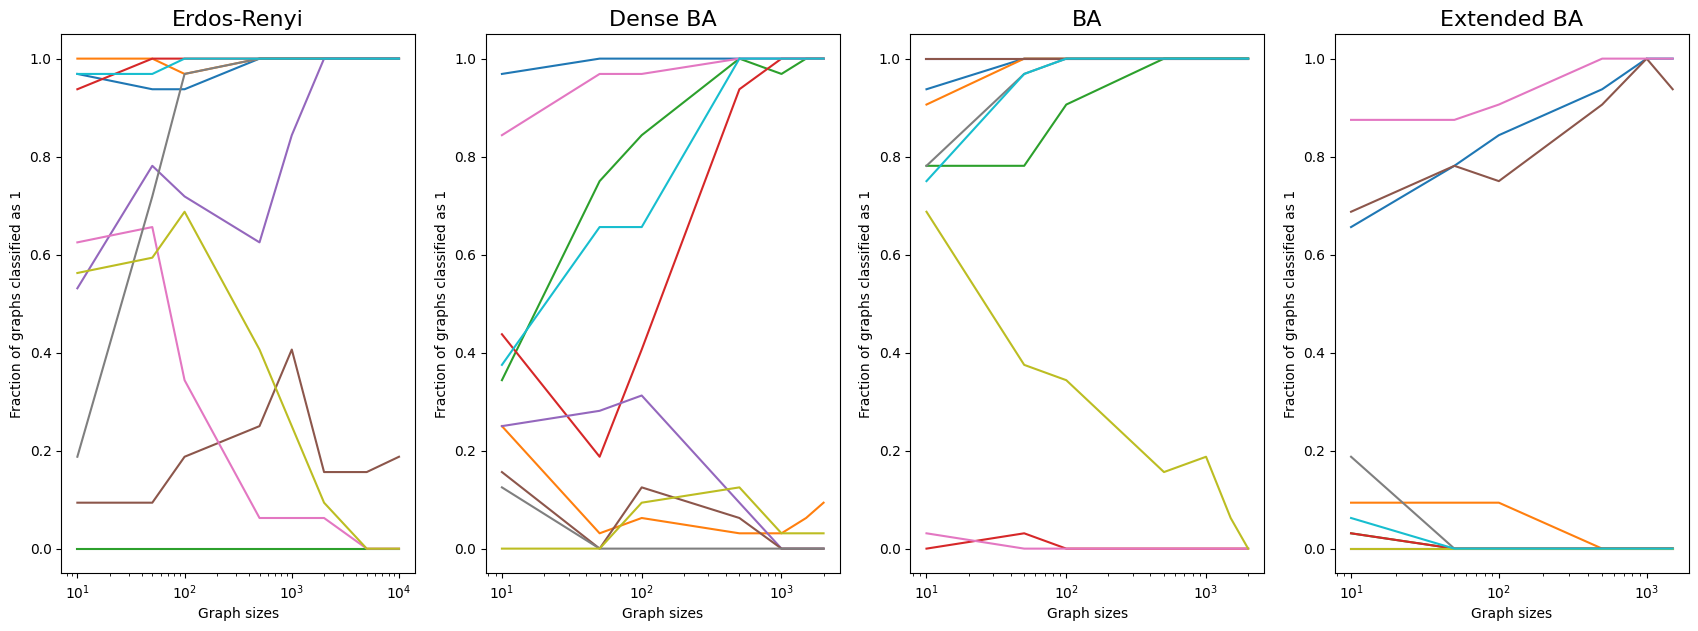

In [74]:

csv = [csv_er, csv_their_ba, csv_ba, csv_ext_ba]
model_names = ["Erdos-Renyi", "Dense BA", "BA", "Extended BA"]
graph_range = [NUM_NODES_er, NUM_NODES_ba_their, NUM_NODES_ba, NUM_NODES_ext]
plot_csv(csv, 32, log_scale=True, title="Binary Graph Classification", subtitles=model_names, xx = graph_range)

In [72]:
csv_er = [[64, 0.5, 3, 0, [31, 30, 30, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 1, [32, 32, 31, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 2, [0, 0, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 3, [30, 32, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 4, [17, 25, 23, 20, 27, 32, 32, 32]],
 [64, 0.5, 3, 5, [3, 3, 6, 8, 13, 5, 5, 6]],
 [64, 0.5, 3, 6, [20, 21, 11, 2, 2, 2, 0, 0]],
 [64, 0.5, 3, 7, [6, 23, 31, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 8, [18, 19, 22, 13, 8, 3, 0, 0]],
 [64, 0.5, 3, 9, [31, 31, 32, 32, 32, 32, 32, 32]]]

csv_ba = [[64, 0.5, 3, 0, [30, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 1, [29, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 2, [25, 25, 29, 32, 32, 32, 32]],
 [64, 0.5, 3, 3, [0, 1, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 4, [32, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 5, [32, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 6, [1, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 7, [25, 31, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 8, [22, 12, 11, 5, 6, 2, 0]],
 [64, 0.5, 3, 9, [24, 31, 32, 32, 32, 32, 32]]]

csv_their_ba = [[64, 0.5, 3, 0, [31, 32, 32, 32, 32, 32, 32]],
 [64, 0.5, 3, 1, [8, 1, 2, 1, 1, 2, 3]],
 [64, 0.5, 3, 2, [11, 24, 27, 32, 31, 32, 32]],
 [64, 0.5, 3, 3, [14, 6, 13, 30, 32, 32, 32]],
 [64, 0.5, 3, 4, [8, 9, 10, 3, 0, 0, 0]],
 [64, 0.5, 3, 5, [5, 0, 4, 2, 0, 0, 0]],
 [64, 0.5, 3, 6, [27, 31, 31, 32, 32, 32, 32]],
 [64, 0.5, 3, 7, [4, 0, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 8, [0, 0, 3, 4, 1, 1, 1]],
 [64, 0.5, 3, 9, [12, 21, 21, 32, 32, 32, 32]]]

csv_ext_ba = [[64, 0.5, 3, 0, [21, 25, 27, 30, 32, 32]],
 [64, 0.5, 3, 1, [3, 3, 3, 0, 0, 0]],
 [64, 0.5, 3, 2, [1, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 3, [1, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 4, [0, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 5, [22, 25, 24, 29, 32, 30]],
 [64, 0.5, 3, 6, [28, 28, 29, 32, 32, 32]],
 [64, 0.5, 3, 7, [6, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 8, [0, 0, 0, 0, 0, 0]],
 [64, 0.5, 3, 9, [2, 0, 0, 0, 0, 0]]]